# Table of Contents
 <p>

In [163]:
%%cython
"""Perlin noise implementation."""
# Licensed under ISC
from itertools import product
import math
import random


cpdef smoothstep(t):
    """Smooth curve with a zero derivative at 0 and 1, making it useful for
    interpolating.
    """
    return t * t * (3. - 2. * t)


cpdef lerp(t, a, b):
    """Linear interpolation between a and b, given a fraction t."""
    return a + t * (b - a)


cdef class PerlinNoiseFactory(object):
    """Callable that produces Perlin noise for an arbitrary point in an
    arbitrary number of dimensions.  The underlying grid is aligned with the
    integers.
    There is no limit to the coordinates used; new gradients are generated on
    the fly as necessary.
    """
    cdef public int dimension
    cdef public int octaves
    cdef public tile
    cdef public unbias
    cdef public scale_factor
    cdef public gradient

    def __init__(self, dimension, octaves=1, tile=(), unbias=False):
        """Create a new Perlin noise factory in the given number of dimensions,
        which should be an integer and at least 1.
        More octaves create a foggier and more-detailed noise pattern.  More
        than 4 octaves is rather excessive.
        ``tile`` can be used to make a seamlessly tiling pattern.  For example:
            pnf = PerlinNoiseFactory(2, tile=(0, 3))
        This will produce noise that tiles every 3 units vertically, but never
        tiles horizontally.
        If ``unbias`` is true, the smoothstep function will be applied to the
        output before returning it, to counteract some of Perlin noise's
        significant bias towards the center of its output range.
        """
        self.dimension = dimension
        self.octaves = octaves
        self.tile = tile + (0,) * dimension
        self.unbias = unbias

        # For n dimensions, the range of Perlin noise is ±sqrt(n)/2; multiply
        # by this to scale to ±1
        self.scale_factor = 2 * dimension ** -0.5

        self.gradient = {}

    def _generate_gradient(self):
        # Generate a random unit vector at each grid point -- this is the
        # "gradient" vector, in that the grid tile slopes towards it

        # 1 dimension is special, since the only unit vector is trivial;
        # instead, use a slope between -1 and 1
        if self.dimension == 1:
            return (random.uniform(-1, 1),)

        # Generate a random point on the surface of the unit n-hypersphere;
        # this is the same as a random unit vector in n dimensions.  Thanks
        # to: http://mathworld.wolfram.com/SpherePointPicking.html
        # Pick n normal random variables with stddev 1
        random_point = [random.gauss(0, 1) for _ in range(self.dimension)]
        # Then scale the result to a unit vector
        scale = sum(n * n for n in random_point) ** -0.5
        return tuple(coord * scale for coord in random_point)

    def get_plain_noise(self, *point):
        """Get plain noise for a single point, without taking into account
        either octaves or tiling.
        """
        if len(point) != self.dimension:
            raise ValueError("Expected {} values, got {}".format(
                self.dimension, len(point)))

        # Build a list of the (min, max) bounds in each dimension
        grid_coords = []
        for coord in point:
            min_coord = math.floor(coord)
            max_coord = min_coord + 1
            grid_coords.append((min_coord, max_coord))

        # Compute the dot product of each gradient vector and the point's
        # distance from the corresponding grid point.  This gives you each
        # gradient's "influence" on the chosen point.
        dots = []
        for grid_point in product(*grid_coords):
            if grid_point not in self.gradient:
                self.gradient[grid_point] = self._generate_gradient()
            gradient = self.gradient[grid_point]

            dot = 0
            for i in range(self.dimension):
                dot += gradient[i] * (point[i] - grid_point[i])
            dots.append(dot)

        # Interpolate all those dot products together.  The interpolation is
        # done with smoothstep to smooth out the slope as you pass from one
        # grid cell into the next.
        # Due to the way product() works, dot products are ordered such that
        # the last dimension alternates: (..., min), (..., max), etc.  So we
        # can interpolate adjacent pairs to "collapse" that last dimension.  Then
        # the results will alternate in their second-to-last dimension, and so
        # forth, until we only have a single value left.
        dim = self.dimension
        while len(dots) > 1:
            dim -= 1
            s = smoothstep(point[dim] - grid_coords[dim][0])

            next_dots = []
            while dots:
                next_dots.append(lerp(s, dots.pop(0), dots.pop(0)))

            dots = next_dots

        return dots[0] * self.scale_factor

    def __call__(self, *point):
        """Get the value of this Perlin noise function at the given point.  The
        number of values given should match the number of dimensions.
        """
        ret = 0
        for o in range(self.octaves):
            o2 = 1 << o
            new_point = []
            for i, coord in enumerate(point):
                coord *= o2
                if self.tile[i]:
                    coord %= self.tile[i] * o2
                new_point.append(coord)
            ret += self.get_plain_noise(*new_point) / o2

        # Need to scale n back down since adding all those extra octaves has
        # probably expanded it beyond ±1
        # 1 octave: ±1
        # 2 octaves: ±1½
        # 3 octaves: ±1¾
        ret /= 2 - 2 ** (1 - self.octaves)

        if self.unbias:
            # The output of the plain Perlin noise algorithm has a fairly
            # strong bias towards the center due to the central limit theorem
            # -- in fact the top and bottom 1/8 virtually never happen.  That's
            # a quarter of our entire output range!  If only we had a function
            # in [0..1] that could introduce a bias towards the endpoints...
            r = (ret + 1) / 2
            # Doing it this many times is a completely made-up heuristic.
            for _ in range(int(self.octaves / 2 + 0.5)):
                r = smoothstep(r)
            ret = r * 2 - 1

        return ret

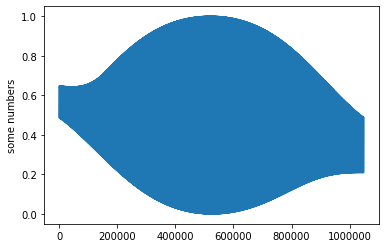

In [173]:
import matplotlib.pyplot as plt
import numpy as np

frameSize = 1024

noise = []

PN = PerlinNoiseFactory(2, 
                        octaves=1,
                        unbias=True
                       )

for i in range(frameSize):
    for j in range(frameSize):
        noise.append(PN(i/frameSize,j/frameSize))

a = np.asarray(noise)
noise = np.interp(a, (a.min(), a.max()), (0, +1))
plt.plot(noise)
plt.ylabel('some numbers')
plt.show()

In [34]:
# Beim Setzen der Farbe der Pixel bereits ein 2D-Array anlegen, dass die Art des Pixels enthält (Beach, Forest, Mountain ...)

In [174]:
noise

array([0.48710408, 0.48771015, 0.48831622, ..., 0.48657223, 0.48712605,
       0.48767653])

In [274]:
%%cython
cimport numpy
import numpy as np
from __main__ import PerlinNoiseFactory

cpdef callPN(int frameSize = 1024, int scale = 300, int dimension = 2, int octaves = 1, bint unbias = True): 

    cdef numpy.ndarray noise = np.zeros((frameSize,frameSize), dtype=np.float)

    PN = PerlinNoiseFactory(dimension=dimension, 
                            octaves=octaves,
                            unbias=unbias
                           )

    cdef int i
    cdef int j
    for i in range(frameSize):
        for j in range(frameSize):
            noise[i,j] = PN(i/scale,j/scale)

    return noise


In [192]:
%%time
callPN()

CPU times: user 7.88 s, sys: 80.5 ms, total: 7.96 s
Wall time: 7.99 s


array([[ 0.        , -0.00075594, -0.00151558, ..., -0.00193394,
        -0.00128493, -0.00064027],
       [-0.00193553, -0.00269147, -0.00345111, ..., -0.00389893,
        -0.00324993, -0.00260528],
       [-0.0038831 , -0.00463903, -0.00539866, ..., -0.00585215,
        -0.00520316, -0.00455852],
       ...,
       [-0.00626319, -0.00620858, -0.00615094, ...,  0.00749585,
         0.00698831,  0.00648099],
       [-0.00416432, -0.00410971, -0.00405209, ...,  0.00551624,
         0.00500862,  0.00450125],
       [-0.00207656, -0.00202195, -0.00196436, ...,  0.00352509,
         0.0030174 ,  0.00250998]])

In [162]:
%%timeit -r 10 -n 10
callPN()

6.82 s ± 441 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


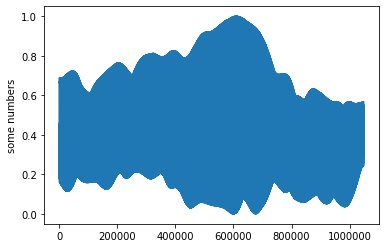

In [252]:
a = callPN(scale=500, octaves=4).flatten()
noise = np.interp(a, (a.min(), a.max()), (0, +1))
plt.plot(noise)
plt.ylabel('some numbers')
plt.show()

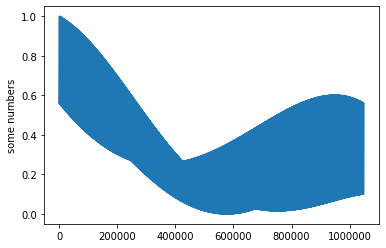

In [191]:
a = callPN().flatten()
noise = np.interp(a, (a.min(), a.max()), (0, +1))
plt.plot(noise)
plt.ylabel('some numbers')
plt.show()

In [196]:
y,x = (1,2)
print(x)
print(y)

2
1


In [204]:
!pwd

/Users/max/Documents/notebooks/perlin


In [207]:
from PIL import Image
from PIL import ImageDraw  
import numpy as np
import random

# Map colours
very_dark_blue = [0,0,89, 255]
dark_blue = [0,0,139, 255] 
blue = [65,105,225, 255]
light_blue = [135,206,250, 255]
green = [34,139,34, 255]
dark_green = [0,100,0, 255]
sandy = [210,180,140, 255]
beach = [238, 214, 175, 255]
snow = [255, 250, 250, 255]
mountain = [139, 137, 137, 255]
gravel = [83,84,78, 255]
dark_gravel = [95,95,90, 255]
light_gravel = [117, 118, 113, 255]
wheat =[245,222,179, 255]

In [278]:
shape = (5000, 5000)

In [279]:
pixels = np.zeros((shape[0], shape[1], 4), dtype=int)

In [249]:
a = callPN(
            scale=500, 
            octaves=4
            ).flatten()
noise = np.interp(a, (a.min(), a.max()), (0, 1))
noise

array([0.46852078, 0.47080779, 0.47316148, ..., 0.12178826, 0.12110837,
       0.12044279])

In [ ]:

size = 5000

shape = (size, size)
pixels = np.zeros((shape[0], shape[1], 4), dtype=int)

a = callPN( frameSize=size,
            scale=7000, 
            octaves=8
            ).flatten()
noise = np.interp(a, (a.min(), a.max()), (0, 1))

for i in range(shape[0]):
    for j in range(shape[1]):
        i = i
        j = j
        index = j+(i * shape[0])
        
        n = noise[index]
        
        if (n < 0.25):
            n = very_dark_blue
        elif (n < 0.45):
            n = dark_blue
        elif (n < 0.54):
            n = blue
        elif (n < 0.55):
            n = light_blue
            #beach_coords.append([i,j])
        elif (n < 0.56 ):
            n = sandy
        elif (n < 0.57 ):
            n = beach
        #elif (n < 0.65):
        #    n = green
        #elif (n < 0.68):
        #    n = wheat
        elif (n < 0.65):
            n = green
        elif (n < 0.75):
            n = dark_green
            #forrest_coords.append([i,j])
        elif (n < 0.77):
            n = gravel
        elif (n < 0.80):
            n = dark_gravel
        elif (n < 0.83):
            n = light_gravel
        elif (n < 0.88):
            n = mountain
        elif (n <= 1.0):
            n = snow
        
        pixels[i,j] = n
        

# Use PIL to create an image from the new array of pixels
new_image = Image.fromarray(np.array(pixels, dtype=np.uint8), 'RGBA')#.resize((5000, 5000), Image.ANTIALIAS)
    
new_image.save('interpolated_18_7000.png')
#new_image.show('interpolated_4.png')

In [ ]:
# Cythonify the mag generator function